Name: Pantelis Zoumpoulidis 

StudentID: 2085764

Candidate Number: 10087

Email: pantelis.zoumpoulidis.2020@bristol.ac.uk

# Question 1

## Introduction

In the first question, we are asked to predict the amount of nitrous oxide (NOX) emitted given the values from nine other sensors around a power station. The first five rows of the dataset that we have to work with are the following:

In [1]:
# import numpy, pandas, and math
import numpy as np
import pandas as pd
import math

# import dataset
dataset = pd.read_csv("/Users/zoumpp/Documents/Data Science MSc/Teaching Block 2 (TB2)/Introduction to Artificial Inteligence/Assessment/Part 1/coursework1.csv")

# display the first five rows
dataset.head(5)

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,NOX
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,81.952
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,82.377
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,83.776
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,82.505
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,82.028


We can see that we already have measurements of NOX based on the other values. That indicates that we have to build a Supervised Learning algorithm. In Supervised Learning, we want to learn an unknown function $f : \Omega \rightarrow \mathcal{O}$  where $\Omega$ is an n-dimensional feature space, and $\mathcal{O}$ is an output space. The aim is to learn an approximation of $f(x)$ from a set of labeled patterns $(x_1, x_2, \cdots, x_n, y)$ where $y = f(x)$. A regression problem is where the output space $\mathcal{O} = \mathbb{R}$, and in our case NOX, takes values ranging from {{min(dataset["NOX"])}} to {{max(dataset["NOX"])}}. Therefore, we need to use Supervised Learning Regression algorithms.

## Methods

The algorithms that we will use in our problem are k-Nearest Neighbors Regression and Polynomial Features Regression.

Because we have to deal with a regression problem, the metric we will use to measure our models' performance is Root Mean Squared Error (RMSE). RMSE is defined as: 


$$ E = \sqrt{\frac{1}{N}{\sum_{i = 1}^{n} (y_i - f(x_i))^2}} $$


So, RMSE is the root of the average of the squared difference between the actual and the predicted values and is always a non-negative real number. That said, the lower the RMSE is, the better the performance of our algorithm is. For example, if our algorithm perfectly predicts all the actual values, then RMSE will be equal to zero.

Also, we are going to need a baseline to compare against our algorithms. That baseline will always predict the mean of the actual values as the predicted values.

Before we begin with our analysis, we need to split the dataset into training and test sets. We will use the training set to train our algorithms in order for them to determine the function $f(x)$, while, the test data will be used to test our algorithm on unseen data. The dataset includes {{np.shape(dataset)[0]}} rows, where each row corresponds to an observation. The test set will consist of 20% ({{round(np.shape(dataset)[0] * 0.2)}}) of random observations from the dataset, while the rest, 80% ({{round(np.shape(dataset)[0] * 0.8)}}), will be used to train and validate our algorithm.

In [2]:
# import train test split
from sklearn.model_selection import train_test_split as tts

# assign features and targets
x = dataset.loc[:, dataset.columns != "NOX"].to_numpy()
y = dataset.loc[:, dataset.columns == "NOX"].to_numpy()

# split into training (tr), and test set (t)
# assign random state to ensure reproducibility
trX, tX, trY, tY = tts(x, y, test_size = 0.2, shuffle = True, random_state = 30032021)

Now, we are ready to start our analysis. First of all, we train the dummy baseline with the training data, make predictions, and calculate the RMSE, which we will use later to compare the models' performance. Due to this model's simplicity, we do not have to tune any hyperparameter or initialize a random state.

In [3]:
# import dummy and mean squared error metric
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse

# instantiate dummy regressor with strategy as mean
dummyRegressor = DummyRegressor(strategy = "mean")

# fit the data to the regressor
dummyRegressor.fit(trX, trY)

# make predictions based on the test data
dummyPredictions = dummyRegressor.predict(tX)

# calculate dummy's root mean squared error
dummyRMSE = mse(dummyPredictions, tY, squared = False)

### k-Nearest Neighbors Regression

The training of the k-nearest neighbors' regression algorithm is acquired just by storing the training set. Then, given a feature vector $\vec{x}$, it finds the k-nearest observations on that dataset where the distance $||\vec{x} - \vec{x_i}||$ is the smallest. Every $\vec{x_i}$ in the dataset is associated with an output value $y_i$. After that, the algorithm will return a predicted value for $\vec{x}$ by weighting the distance of $\vec{x}$ with every $\vec{x_i}$, where $\hat{f}(\vec{x})$ is:

$$\hat{f}(\vec{x}) = \frac{\sum_{i = 1}^{k}w_i y_i}{\sum_{i = 1}^{k}w_i}, \qquad w_i = \frac{1}{||\vec{x} - \vec{x_i}||}$$

Hence, the hyperparameter we need to tune for this algorithm is the number of k-neighbors that need to be taken into account during the prediction process. To find the optimal k, we will use cross-validation.

#### Cross-Validation

Before we begin, we set a range of values to test for the hyperparameter (in our example 1 up to 50 k-neighbors). In the cross-validation method, we split the training set into several $K$ segments (folds). One segment is used as the validation set, while the rest $K - 1$ folds are assigned as the training data. We loop over the segments until every fold had the role of validation data once. In every loop, we calculate the RMSE on the training data and the validation data. We repeat the cross-validation process for every value of the hyperparameter we specified earlier. After that, we estimate the average of RMSE for each hyperparameter value. Finally, we will use the value, which returned the minimum RMSE on the validation data, as the optimal hyperparameter and apply it on our unseen data.

In [4]:
# import k-neighbors regressor, kfold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold

# instantiate KFold with 10 splits. 
# assign random state to ensure reproducibility
crossValidation = KFold(n_splits = 10, shuffle = True, random_state = 30032021)

# set k neighbors to test
maxKNeighbors = 50

# initialize two variables to store the training RMSE and validation RMSE 
trainRMSE = [[] for _ in range(maxKNeighbors)]
valRMSE = [[] for _ in range(maxKNeighbors)]

# loop over the values of k neighbors: 
for k in range(maxKNeighbors):
    
    # instantiate a k-nn regressor with the current value of k
    knr = KNeighborsRegressor(n_neighbors = k + 1)
    
    # Loop over the K-Folds: 
    for trIndex, valIndex in crossValidation.split(trX):
        
        # assign training and validation sets
        trainX, valX, trainY, valY = trX[trIndex], trX[valIndex], trY[trIndex], trY[valIndex]
        
        # fit the data to the regressor
        knr.fit(trainX, trainY)
        
        # make predictions 
        trainPredictions = knr.predict(trainX)
        valPredictions = knr.predict(valX)
        
        # calculate training and validation RMSE, and store 
        trainRMSE[k].append(mse(trainPredictions, trainY, squared = False))
        valRMSE[k].append(mse(valPredictions, valY, squared = False))

# Calculate the mean training and validation RMSEs across splits for each k
meanTrainKnrRMSE = np.mean(trainRMSE, axis = 1)
meanValKnrRMSE = np.mean(valRMSE, axis = 1)

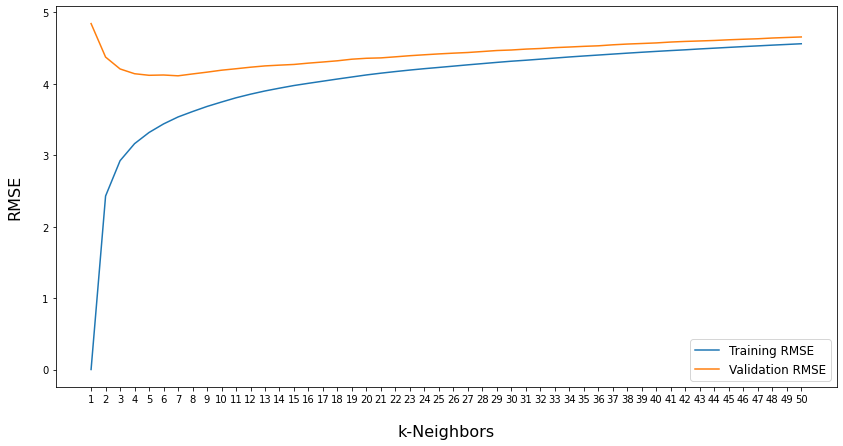

In [5]:
# import matplot
import matplotlib.pyplot as plt

# Plot the mean training and validation RMSEs
x = range(1, maxKNeighbors + 1)
plt1, ax1 = plt.subplots(figsize = (14, 7))
ax1.plot(x, meanTrainKnrRMSE, label = "Training RMSE")
ax1.plot(x, meanValKnrRMSE, label = "Validation RMSE")
ax1.legend(prop = {"size" : 12})
ax1.set_xlabel("k-Neighbors", size = 16, labelpad = 20)
ax1.set_ylabel("RMSE", size = 16, labelpad = 20)
trash = ax1.set_xticks(range(1, maxKNeighbors + 1, 1))

We can notice that the validation RMSE is constantly decreasing after the seventh k-neighbor, making no difference to test higher hyperparameter values than the ones that we already did. Based on the previous plot, the number of k-neighbors that returns the minimum RMSE ({{round(min(meanValKnrRMSE), 4)}}) on the validation data is {{np.argmin(meanValKnrRMSE) + 1}}. Hence, that is the value that we will use as the optimal hyperparameter to predict the test set's values. After predicting the values, we will calculate the k-Nearest Neighbors' Regression RMSE, which we will use to compare this model versus the other models.

In [6]:
# instantiate the knn regressor with the optimal k
knr = KNeighborsRegressor(n_neighbors = np.argmin(meanValKnrRMSE) + 1)

# fit the data to the regressor
knr.fit(trX, trY)

# make predictions based on the test data
knrPredictions = knr.predict(tX)

# calculate the knnr's RMSE
knrRMSE = mse(knrPredictions, tY, squared = False)

### Polynomial Features Regression

Suppose we have a dataset where the values are a product of a polynomial feature (e.g., $y = x^2$). Polynomial Features is an algorithm that transforms the data so we can add powers of the original features as new features. For example, if we have a dataset that consists of one feature and its values, it can transform it from $y = ax +b$ to $y = a_2 x^2 + a_1 x + b$. Thence, we can utilize a linear regressor to fit the model and predict values. A linear regressor tries to select coefficients $b, a_0, \cdots, a_n$ in order to minimize the mean squared error over the training set for every possible training pattern. To achieve this, it needs to minimize the value of $E = \frac{1}{N}\sum_{(x, y)}{(y - ax - b) ^ 2}$, which is a quadratic curve. That means it has a single global minimum which can be measured by differentiating $E$ with respect to $a$ and $E$ with respect to $b$. To generalize this, suppose we have $y$, which is a single column vector of the actual values; $Θ$, which is a single column vector of model parameters; $X$, which is a matrix of all the values of features plus a column of ones in the end for the coefficients. Consequently, $E = (y - X Θ)^{Τ}(y - Χ Θ)$. The goal is to minimize E, and to accomplish that, the differentiation of it with respect to $Θ$ is needed. Thus, the equation that returns the optimal coefficients is the following:

$$\hat{Θ} = (X^{T}X)^{-1}X^{T}y$$

The hyperparameter of Polynomial Features is the number of degrees. We will find the optimal value by applying cross-validation on the training set, similar to what we did earlier with the k-Nearest Neighbors algorithm.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# instantiate KFold with 10 splits. 
# assign random state to ensure reproducibility
crossValidation = KFold(n_splits = 10, shuffle = True, random_state = 30032021)

# set degrees to test
maxDegree = 6

# initialize two variables to store the training RMSE and validation RMSE 
trainRMSE = [[] for _ in range(maxDegree)]
valRMSE = [[] for _ in range(maxDegree)]

# loop over the values of degrees: 
for i in range(maxDegree):
    
    # instantiate polynomial features with the current value of i (degree)
    pf = PolynomialFeatures(degree = i + 1)
    
    # Loop over the K-Folds: 
    for trIndex, valIndex in crossValidation.split(trX):
        
        # assign training and validation sets
        trainX, valX, trainY, valY = trX[trIndex], trX[valIndex], trY[trIndex], trY[valIndex]
        
        # transform the data
        transformedTrX = pf.fit_transform(trainX)
        transformedVX = pf.fit_transform(valX)
        
        # instantiate the regressor
        lr = LinearRegression()
        
        # fit the data to the regressor
        lr.fit(transformedTrX, trainY)
        
        # make predictions 
        trainPredictions = lr.predict(transformedTrX)
        valPredictions = lr.predict(transformedVX)
        
        # calculate training and validation RMSE, and store 
        trainRMSE[i].append(mse(trainPredictions, trainY, squared = False))
        valRMSE[i].append(mse(valPredictions, valY, squared = False))

# Calculate the mean training and validation RMSEs across splits for each degree
meanTrainPfRMSE = np.mean(trainRMSE, axis = 1)
meanValPfRMSE = np.mean(valRMSE, axis = 1)

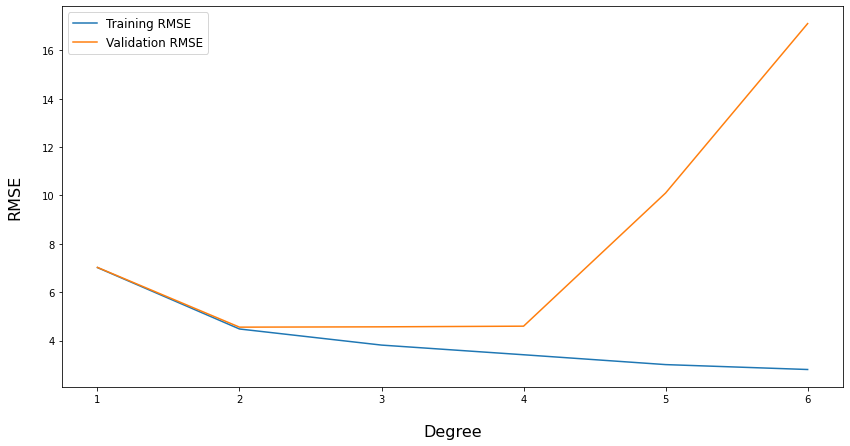

In [8]:
# plot training and validation RMSE
x = range(1, maxDegree + 1, 1)
plt2, ax2 = plt.subplots(figsize = (14, 7))
ax2.plot(x, meanTrainPfRMSE, label = "Training RMSE")
ax2.plot(x, meanValPfRMSE, label = "Validation RMSE")
ax2.legend(prop = {"size" : 12})
ax2.set_xlabel("Degree", size = 16, labelpad = 20)
ax2.set_ylabel("RMSE", size = 16, labelpad = 20)
trash = ax2.set_xticks(x)

We did not test more than six polynomial degrees because, as we can perceive in the graph above, after the fourth degree, the validation RMSE is increasing while the training RMSE tends to become zero. That is a consequence of overfitting; the more significant the polynomial degree is, the more unbiased the function will be towards the training set. The other thing that we can figure out by investigating the last plot is that we get the lowest RMSE ({{round(min(meanValPfRMSE), 4)}}) on the validation data by setting the degree to {{np.argmin(meanValPfRMSE) + 1}}. Consequently, that value will be the optimal hyperparameter for our Polynomial Features model. Following this, we will predict the values on the test set and then calculate the RMSE on the test set.

In [9]:
# instantiate polynomial features with the optimal degree
pf = PolynomialFeatures(degree = np.argmin(meanValPfRMSE) + 1)

# transform the data
transformedTrainX = pf.fit_transform(trX)
transformedTestX = pf.fit_transform(tX)

# instantiate the regressor
lr = LinearRegression()

# fit the data to the regressor
lr.fit(transformedTrainX, trY)

# make predictions
pfPredictions = lr.predict(transformedTestX)

# calculate polynomial features' RMSE
pfRMSE = mse(pfPredictions, tY, squared = False)

## Results

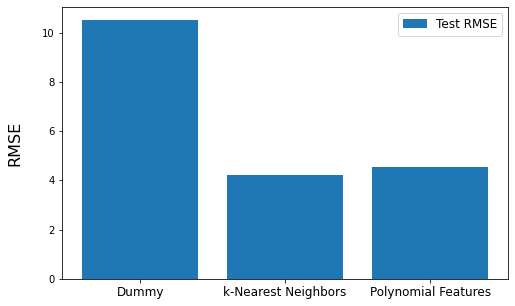

In [10]:
# Plot the test RMSEs
plt3, ax3 = plt.subplots(figsize = (8, 5))
x = [1, 2, 3]
ax3.bar(x, [dummyRMSE, knrRMSE, pfRMSE], width = 0.8, label = "Test RMSE")
ax3.legend(prop = {"size" : 12})
ax3.set_ylabel("RMSE", size = 16, labelpad = 20)
ax3.set_xticks(x)
trash = ax3.set_xticklabels(["Dummy", "k-Nearest Neighbors", "Polynomial Features"], size = 12)

By investigating the plot above, we can quickly conclude that the dummy model did not perform as well as the other two models. Between k-Nearest Neighbors and Polynomial Features, we can see that the former performs slightly better than the second. We will plot the actual values against the predicted values on a scatter plot for each of the models to justify our verdict. If the predictions are perfect, the points will lie on a $y = x$ line.

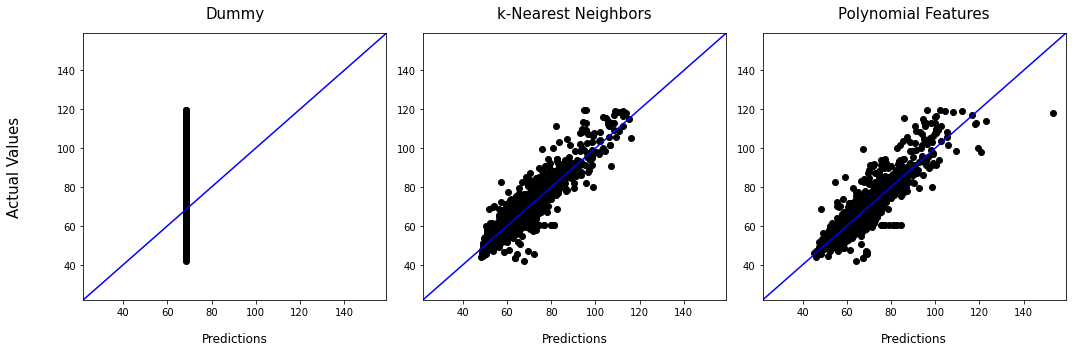

In [11]:
# min value of NOX between the actual and them predicted values
minValue = min([np.min(dummyPredictions), np.min(knrPredictions), np.min(pfPredictions), np.min(trY), np.min(tY)])
# max value of NOX between the actual and them predicted values
maxValue = max([np.max(dummyPredictions), np.max(knrPredictions), np.max(pfPredictions), np.min(trY), np.min(tY)])
# range of NOX values
rangeOfValues = round(maxValue - minValue)
# lower limit a little smaller than the min value
yLowerLimit = round(minValue - (rangeOfValues * 0.05))
# upper limit a little bigger than the max value
yUpperLimit = round(maxValue + (rangeOfValues * 0.05))
# create the y = x line
lX = range(yLowerLimit, yUpperLimit + 1)
lY = lX

# plot actual values vs prediction for every algorithm
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
axes[0].set_ylim(yLowerLimit, yUpperLimit)
axes[0].set_xlim(yLowerLimit, yUpperLimit)
axes[0].scatter(dummyPredictions, tY, color = "black")
axes[0].plot(lX, lY, color = "blue")
axes[0].set_title("Dummy", size = 15, pad = 15)

axes[1].set_ylim(yLowerLimit, yUpperLimit)
axes[1].set_xlim(yLowerLimit, yUpperLimit)
axes[1].scatter(knrPredictions, tY, color = "black")
axes[1].plot(lX, lY, color = "blue")
axes[1].set_title("k-Nearest Neighbors", size = 15, pad = 15)

axes[2].set_ylim(yLowerLimit, yUpperLimit)
axes[2].set_xlim(yLowerLimit, yUpperLimit)
axes[2].scatter(pfPredictions, tY, color = "black")
axes[2].plot(lX, lY, color = "blue")
axes[2].set_title("Polynomial Features", size = 15, pad = 15)

axes[0].set_ylabel("Actual Values", size = 15, labelpad = 35)
axes[0].set_xlabel("Predictions", size = 12, labelpad = 15)
axes[1].set_xlabel("Predictions", size = 12, labelpad = 15)
axes[2].set_xlabel("Predictions", size = 12, labelpad = 15)

fig.tight_layout()

As we were expecting, the scatter plot with dummy predictions is a parallel line with axis $y$. The reason is that the algorithm returned for every prediction the average of actual training values. Moving on, we can see that the points on the scatter plots of the other two algorithms are gathered around the line $x = y$. That means that the predictions are pretty close to the actual values. We can also observe that the Polynomial Features algorithm does not perform pretty well with the highest values. We can easily understand that observing the spread of the data points away from the blue line after the 100th value. To conclude, for the reasons mentioned earlier and for the difference in the values of RSME on the test set, we deduce that the k-Nearest Neighbors regression performs better than the other algorithms.

To summarise, we introduced our problem, picked suitable regression algorithms and an appropriate performance metric. We used a portion of the given dataset to train those algorithms and applied the performance metric to tune their hyperparameters. Then, we made predictions on unseen data and compared the algorithms' results against the actual values.

References:

https://web.microsoftstream.com/video/28225631-e582-4253-bc5c-dc6a40d60a3b

https://web.microsoftstream.com/video/3f36fcfc-6601-4c16-b578-55da690842b5

https://towardsdatascience.com/polynomial-regression-bbe8b9d97491

https://stats.stackexchange.com/questions/58739/polynomial-regression-using-scikit-learn